## Data Science Bowl 2018: Image Segmentation using U-Net

**Introduction:**

This notebook demonstrates the application of the U-Net architecture for image segmentation using the Data Science Bowl 2018 dataset. The notebook provides a concise overview of the dataset, the U-Net model, and the steps involved in training and evaluating the model for image segmentation.

**Dataset:**

The Data Science Bowl 2018 dataset consists of a large collection of images and corresponding segmentation masks. The images depict various biological structures, such as cells and nuclei, and the masks provide pixel-level annotations of these structures.

**U-Net Model:**

The U-Net model is a deep learning architecture specifically designed for image segmentation. It utilizes a convolutional neural network (CNN) with a unique encoder-decoder structure. The encoder progressively downsamples the input image to extract high-level features, while the decoder gradually upsamples the encoded features and combines them with lower-level features to produce a final segmentation mask.

**Steps:**

1. **Data Preparation:**
    - Load the Data Science Bowl 2018 dataset.
    - Preprocess the images and masks by resizing, and normalization.

2. **Model Training:**
    - Initialize the U-Net model with appropriate hyperparameters.
    - Train the model using the training set and optimize the model parameters based on a chosen loss function.
    - Monitor the training process and evaluate the model performance on the validation set.

3. **Evaluation:**
    - Visualize the predicted segmentation masks and compare them with the ground truth masks.

**Conclusion:**

This notebook successfully demonstrates the application of the U-Net architecture for image segmentation using the Data Science Bowl 2018 dataset. The provided code and explanations offer a comprehensive guide for understanding and implementing the U-Net model for image segmentation tasks.

**Acknowledgement**
Thanks to DigitalSreeni https://www.youtube.com/watch?v=RaswBvMnFxk&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=6 for U-Net tutorial.

In [1]:
from google.colab import files

#upload kaggle.json file
uploaded = files.upload()

# Make a directory called .kaggle in the user's home directory.
!mkdir -p ~/.kaggle

# Move the uploaded kaggle.json file to the .kaggle directory.
!mv kaggle.json ~/.kaggle/

# Change the permissions of the kaggle.json file to 600.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c data-science-bowl-2018

 99% 353M/358M [00:04<00:00, 105MB/s] 
100% 358M/358M [00:04<00:00, 88.9MB/s]


In [3]:
!unzip data-science-bowl-2018.zip -d data-science-bowl-2018

Archive:  data-science-bowl-2018.zip
  inflating: data-science-bowl-2018/stage1_sample_submission.csv.zip  
  inflating: data-science-bowl-2018/stage1_solution.csv.zip  
  inflating: data-science-bowl-2018/stage1_test.zip  
  inflating: data-science-bowl-2018/stage1_train.zip  
  inflating: data-science-bowl-2018/stage1_train_labels.csv.zip  
  inflating: data-science-bowl-2018/stage2_sample_submission_final.csv.zip  
  inflating: data-science-bowl-2018/stage2_test_final.zip  


In [4]:
import os
import zipfile

# Get the path to the data-science-bowl-2018 directory.
data_dir = os.path.join(os.getcwd(), "data-science-bowl-2018")

# Get a list of all the zip files in the data-science-bowl-2018 directory.
zip_files = [f for f in os.listdir(data_dir) if f.endswith(".zip")]

# Unzip each zip file in the data-science-bowl-2018 directory.
for zip_file in zip_files:
  # Get the path to the zip file.
  zip_file_path = os.path.join(data_dir, zip_file)

  # Get the name of the folder that the zip file should be extracted to.
  folder_name = zip_file.split(".")[0]

  # Get the path to the folder that the zip file should be extracted to.
  folder_path = os.path.join(data_dir, folder_name)

  # Unzip the zip file to the folder.
  with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(folder_path)

In [5]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.transform import resize
from skimage.io import imread, imshow
from skimage.color import gray2rgb

In [6]:
train_dir = os.path.join(os.getcwd(), "data-science-bowl-2018/stage1_train")
test_dir = os.path.join(os.getcwd(), "data-science-bowl-2018/stage1_test")

In [7]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50

np.random.seed(42)
tf.random.set_seed(42)

In [8]:
train_ids = os.listdir(train_dir)
test_ids = os.listdir(test_dir)

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

In [9]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(train_dir, id_)
    img = imread(os.path.join(path, "images", id_ + ".png"))[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True)
    X_train[n] = img

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    for mask_file in os.listdir(os.path.join(path, "masks")):
        mask_ = imread(os.path.join(path, "masks", mask_file))
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

100%|██████████| 670/670 [05:28<00:00,  2.04it/s]


In [10]:
#test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(test_dir, id_)
    img = imread(os.path.join(path, "images", id_ + ".png"))[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True)
    X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 43.07it/s]


In [11]:
X_train = X_train/255.0
X_test = X_test/255.0

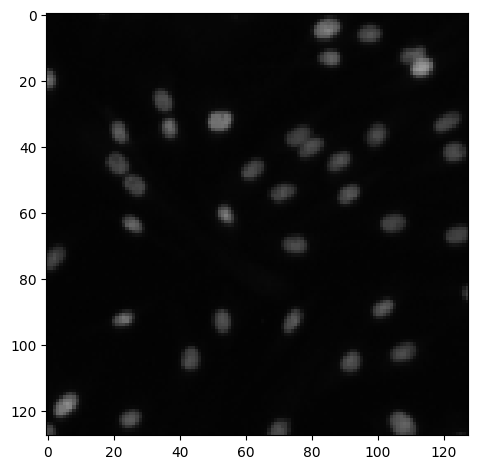

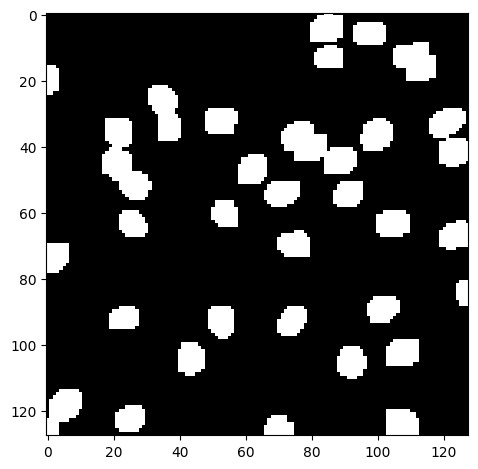

In [12]:
#plot random image
sample_idx = np.random.randint(len(X_train))
imshow(X_train[sample_idx])
plt.show()
imshow(Y_train[sample_idx])
plt.show()

In [13]:
inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

#contractive path
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)

c2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c1)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)

c3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c2)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)

c4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c3)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)

c5 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5) #shape 8x8x256

#expansion path
c6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
c6 = tf.keras.layers.concatenate([c4,c6])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

c7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
c7 = tf.keras.layers.concatenate([c3,c7])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

c8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
c8 = tf.keras.layers.concatenate([c2,c8])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

c9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
c9 = tf.keras.layers.concatenate([c1,c9])
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

outputs =  tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [14]:
#checkpoints and callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True)
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2),
             checkpoint]

In [15]:
results = model.fit(X_train,Y_train,validation_split=0.1,batch_size=16,epochs=50,callbacks=callbacks)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.7512
Epoch 1: val_loss improved from inf to 0.55872, saving model to model.h5
38/38 [==============================] - 23s 172ms/step - loss: 0.6526 - accuracy: 0.7512 - val_loss: 0.5587 - val_accuracy: 0.7623
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/38 [============================>.] - ETA: 0s - loss: 0.4325 - accuracy: 0.7628
Epoch 2: val_loss improved from 0.55872 to 0.30998, saving model to model.h5
38/38 [==============================] - 2s 57ms/step - loss: 0.4306 - accuracy: 0.7637 - val_loss: 0.3100 - val_accuracy: 0.8105
Epoch 3/50
37/38 [============================>.] - ETA: 0s - loss: 0.2607 - accuracy: 0.8832
Epoch 3: val_loss improved from 0.30998 to 0.25460, saving model to model.h5
38/38 [==============================] - 2s 57ms/step - loss: 0.2579 - accuracy: 0.8846 - val_loss: 0.2546 - val_accuracy: 0.9010
Epoch 4/50
37/38 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9320
Epoch 4: val_loss improved from 0.25460 to 0.17139, saving model to model.h5
38/38 [==============================] - 2s 55ms/step - loss: 0.1766 - accuracy: 0.9320 - val_loss: 0.1714 - val_accuracy: 0.9331
Epoch 5/50
38/38 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9377
Epoch 5: val_l

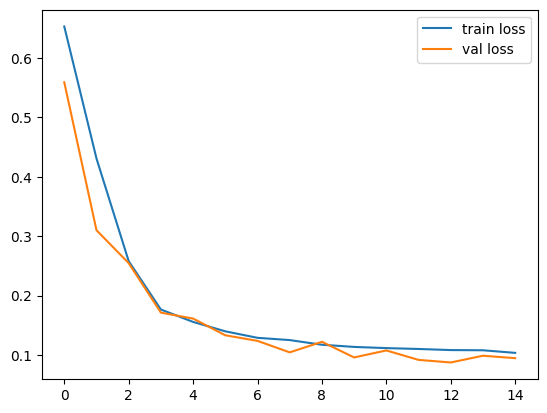

In [16]:
plt.plot(results.history['loss'],label='train loss')
plt.plot(results.history['val_loss'],label='val loss')
plt.legend()
plt.show()

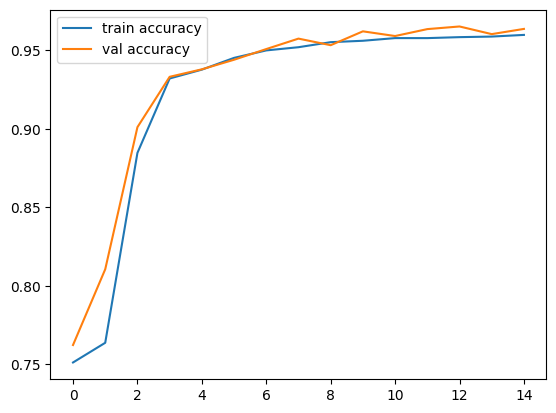

In [17]:
plt.plot(results.history['accuracy'],label='train accuracy')
plt.plot(results.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.show()

3/3 [==============================] - 2s 14ms/step


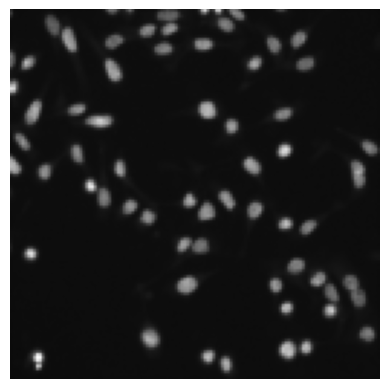

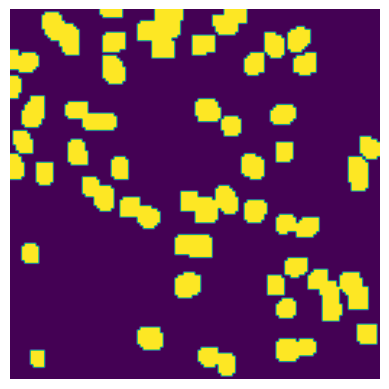

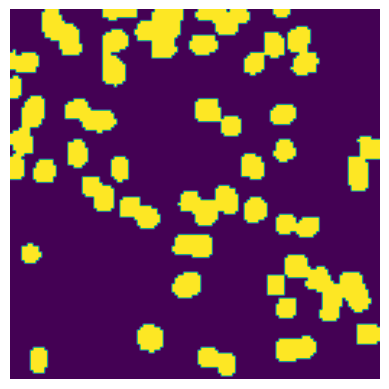

In [18]:
#select sample image and plot ground truth and predicted mask
val_pred = model.predict(X_train[int(X_train.shape[0]*0.9):])
pred_mask = val_pred > 0.5

sample_idx = np.random.randint(len(val_pred))
plt.imshow(X_train[int(X_train.shape[0]*0.9):][sample_idx])
plt.axis('off')
plt.show()
plt.imshow(Y_train[int(Y_train.shape[0]*0.9):][sample_idx])
plt.axis('off')
plt.show()
plt.imshow(pred_mask[sample_idx])
plt.axis('off')
plt.show()